# Birds
## How to use this notebook
### Imports
TODO: Write which packages the user has to import to use this notebook. Something like:
> pip install pandas matplotlib numpy seaborn basemap etc..

### Data
In order to run this notebook you must first extract `birds.csv` from `birds.zip`

In [14]:
# TODO: Cleanup imports that are not needed
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import itertools
import collections
import json
import nltk
from nltk.corpus import stopwords
# from dwca.read import DwCAReader
from mpl_toolkits.basemap import Basemap
from IPython.display import display
import re
pd.set_option("display.max_columns", None)
import datetime
import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

## Importing data
We start by reading the file to a dataframe:

In [15]:
birds = pd.read_csv("birds.csv", index_col=False)
display(birds.head())
print("Number of rows:", birds.shape[0])

,vernacularName,verbatimScientificName,order,family,genus,specificEpithet,eventDate,year,month,day,stateProvince,locality,decimalLatitude,decimalLongitude,individualCount,iucnRedListCategory
0,Lesser Black-backed Gull,Larus fuscus,Charadriiformes,Laridae,Larus,fuscus,2016-05-31T00:00:00,2016,5,31,Suðurland,Heimaey--Víkin,63.408356,-20.280504,1.0,LC
1,Ruddy Turnstone,Arenaria interpres,Charadriiformes,Scolopacidae,Arenaria,interpres,2004-09-17T00:00:00,2004,9,17,Suðurnes,Garður,64.072426,-22.660074,NaN,LC
2,Glaucous Gull,Larus hyperboreus,Charadriiformes,Laridae,Larus,hyperboreus,2010-11-24T00:00:00,2010,11,24,Norðurland eystra,Húsavík--hafnarsvæði (harbour area),66.044800,-17.349987,NaN,LC
3,Eurasian Wigeon,Mareca penelope,Anseriformes,Anatidae,Anas,penelope,2018-06-24T00:00:00,2018,6,24,Suðurland,"(63.6731,-20.3561)",63.673130,-20.356092,2.0,LC
4,Mallard,Anas platyrhynchos,Anseriformes,Anatidae,Anas,platyrhynchos,2020-02-29T00:00:00,2020,2,29,Vestfirðir,Bolungarvik--hafnarsvaedi (harbour area),66.157510,-23.244152,11.0,LC


Number of rows: 751153


Most of these columns are self-explanatory but there are a couple of things we want to clear up.

`verbatimScientificName` is the [binomial name](https://en.wikipedia.org/wiki/Binomial_nomenclature) of the species. This is also the same as the columns `genus`+ `specificEpithet`. 

Regarding the [taxonomic rank](https://en.wikipedia.org/wiki/Taxonomic_rank), we only include `order`, `family`, `genus` and `specificEpithet` and exclude `kingdom`, `phylum` and `class`, since these fields would be identical for all records (*Animalia*, *Chordata* and *Aves*)

The column `individualCount` says how many birds of the given species were spotted at the given time and location.

`iucnRedListCategory` is the [conservation status](https://www.iucnredlist.org/) of the species.

![](images/Status_iucn3.1.svg.png)

## Cleaning data
There are a couple of duplicated rows which we can remove:

TODO: Perhaps show some duplicated rows

In [16]:
print("Number of rows:", birds.shape[0])

dupes = birds[birds.duplicated(keep=False)]
dupes = dupes.sort_values(by=["vernacularName"])
display(dupes[["vernacularName","individualCount", "eventDate", "locality"]].head())

birds = birds.drop_duplicates()
print("Number of rows:", birds.shape[0])

Number of rows: 751153


,vernacularName,individualCount,eventDate,locality
489067,Alder Flycatcher,1.0,2020-09-21T00:00:00,Sólveigarlundur
8208,Alder Flycatcher,1.0,2003-10-10T00:00:00,Eyjafjöll--Kverkin
498121,Alder Flycatcher,1.0,2020-09-21T00:00:00,Miðnes--Hvalsnes
176514,Alder Flycatcher,1.0,2020-09-23T00:00:00,Miðnes--Hvalsnes
212790,Alder Flycatcher,1.0,2020-09-21T00:00:00,Miðnes--Hvalsnes


Number of rows: 655657


There are some rows where `individualCount` is NaN. We think it's safe to replace these values with 1.

TODO: Rationalize why we think we can replace theses values. Similar case here: https://github.com/nmtarr/wildlife-wrangler/blob/master/wrangler_functions.py#L443

In [17]:
print("Before")
display(birds[["vernacularName","individualCount"]].head())
birds["individualCount"] = birds["individualCount"].fillna(value=1)
print("After")
display(birds[["vernacularName","individualCount"]].head())

Before


,vernacularName,individualCount
0,Lesser Black-backed Gull,1.0
1,Ruddy Turnstone,NaN
2,Glaucous Gull,NaN
3,Eurasian Wigeon,2.0
4,Mallard,11.0


After


,vernacularName,individualCount
0,Lesser Black-backed Gull,1.0
1,Ruddy Turnstone,1.0
2,Glaucous Gull,1.0
3,Eurasian Wigeon,2.0
4,Mallard,11.0


In [18]:
# Not sure if this should be included in the final product
# but it is helpful to have a list of bird names

# Unique bird species
bird_names = birds["vernacularName"].unique().tolist()
bird_names.sort()
for name in bird_names:
    print(name)

print("Number of unique bird species:", len(bird_names))

Acadian Flycatcher
Alder Flycatcher
Alpine Swift
American Black Duck
American Coot
American Golden-Plover
American Pipit
American Redstart
American Robin
American Wigeon
Arctic Loon
Arctic Tern
Arctic Warbler
Atlantic Puffin
Baird's Sandpiper
Baltimore Oriole
Bank Swallow
Bar-headed Goose
Bar-tailed Godwit
Barn Swallow
Barnacle Goose
Barred Warbler
Barrow's Goldeneye
Belted Kingfisher
Black Guillemot
Black Kite
Black Redstart
Black Scoter
Black Stork
Black Swan
Black Tern
Black-and-white Warbler
Black-bellied Plover
Black-crowned Night-Heron
Black-headed Gull
Black-legged Kittiwake
Black-tailed Godwit
Black-throated Blue Warbler
Black-throated Green Warbler
Black-throated Thrush
Black-winged Stilt
Blackpoll Warbler
Blue-winged Teal
Bluethroat
Blyth's Reed Warbler
Bohemian Waxwing
Bonaparte's Gull
Brambling
Brant
Broad-billed Sandpiper
Buff-breasted Sandpiper
Bufflehead
Cackling Goose
Canada Goose
Canada Warbler
Carrion Crow
Caspian Gull
Cattle Egret
Cedar Waxwing
Cerulean Warbler
Citri

## Icelandic names and rarity
We made a `.csv` file for the species above that had the columns `vernacularName` and `verbatimScientificName`.

We added two columns to this `.csv` file: `icelandicName` and `rarity`.
The Icelandic names were manually looked up on [eBird](https://ebird.org/).

The rarity was found on a [List of Icelandic Bird Species](https://notendur.hi.is/yannk/1111.pdf) from the University of Iceland. Species with an `"F"` in the 6th column are considered rare in Iceland.

Here we import our `.csv` file:

In [19]:
bird_names_and_rarity = pd.read_csv("bird_names_and_rarity.csv", index_col=False)
# Note: We remove the verbatimScientificName column to prepare the join with the birds dataframe below
bird_names_and_rarity.drop(["verbatimScientificName"], axis=1, inplace=True)
display(bird_names_and_rarity.head())

,vernacularName,icelandicName,rare
0,Common Redpoll,Auðnutittlingur,NaN
1,Hoary Redpoll,Hrímtittlingur,F
2,Eurasian Sparrowhawk,Sparrhaukur,F
3,Paddyfield Warbler,Dvalsöngvari,F
4,Blyth's Reed Warbler,Elrisöngvari,F


We want the values in the `rare` column to be more descriptive so we replace `F` with `True` and `NaN` with `False`.

We also drop the `verbatimScientificName` to prepare the merge with the `birds` dataframe.

In [20]:
bird_names_and_rarity["rare"] = bird_names_and_rarity["rare"].replace("F", True)
bird_names_and_rarity["rare"] = bird_names_and_rarity["rare"].fillna(False)
display(bird_names_and_rarity.head())

,vernacularName,icelandicName,rare
0,Common Redpoll,Auðnutittlingur,False
1,Hoary Redpoll,Hrímtittlingur,True
2,Eurasian Sparrowhawk,Sparrhaukur,True
3,Paddyfield Warbler,Dvalsöngvari,True
4,Blyth's Reed Warbler,Elrisöngvari,True


We can now merge the dataframe `bird_names_and_rarity` with our main dataframe, `birds`.

In [21]:
# NOTE: Do not run this cell more than once.
#       Doing so will result in multiple icelandicName and rare columns in birds
birds = pd.merge(birds, bird_names_and_rarity, how="inner", on="vernacularName")

In [45]:
birds = birds.sample(frac=1).reset_index(drop=True) # This randomly shuffles the rows, to make the output look more interesting 
display(birds.head())

,vernacularName,icelandicName,verbatimScientificName,order,family,genus,specificEpithet,eventDate,year,month,day,stateProvince,locality,decimalLatitude,decimalLongitude,individualCount,iucnRedListCategory,rare
0,Eurasian Oystercatcher,Tjaldur,Haematopus ostralegus,Charadriiformes,Haematopodidae,Haematopus,ostralegus,2014-06-30T00:00:00,2014,6,30,Norðurland eystra,Húsavík--hafnarsvæði (harbour area),66.044800,-17.349987,3.0,NT,False
1,Redwing,Skógarþröstur,Turdus iliacus,Passeriformes,Turdidae,Turdus,iliacus,2003-09-03T00:00:00,2003,9,3,Norðurland eystra,Kaldbakstjarnir,66.021540,-17.367798,1.0,NT,False
2,Long-tailed Duck,Hávella,Clangula hyemalis,Anseriformes,Anatidae,Clangula,hyemalis,2015-06-06T00:00:00,2015,6,6,Norðurland eystra,Laxárós (river mouth),65.986465,-17.427750,4.0,VU,False
3,Great Cormorant,Dílaskarfur,Phalacrocorax carbo,Suliformes,Phalacrocoracidae,Phalacrocorax,carbo,2016-10-19T00:00:00,2016,10,19,Norðurland eystra,Bakkakrókur,66.072350,-17.352476,2.0,LC,False
4,European Golden-Plover,Heiðlóa,Pluvialis apricaria,Charadriiformes,Charadriidae,Pluvialis,apricaria,2016-09-21T00:00:00,2016,9,21,Suðurnes,Sandgerði--leira (mudflat),64.035324,-22.710371,300.0,LC,False


Here we reorder the columns to put `icelandicName` in the second column. 

In [46]:
reordered_cols = [
    'vernacularName',
    'icelandicName',
    'verbatimScientificName',
    'order',
    'family',
    'genus',
    'specificEpithet',
    'eventDate',
    'year',
    'month',
    'day',
    'stateProvince',
    'locality',
    'decimalLatitude',
    'decimalLongitude',
    'individualCount',
    'iucnRedListCategory',
    'rare'
    ]
birds = birds[reordered_cols]
display(birds.head())

,vernacularName,icelandicName,verbatimScientificName,order,family,genus,specificEpithet,eventDate,year,month,day,stateProvince,locality,decimalLatitude,decimalLongitude,individualCount,iucnRedListCategory,rare
0,Eurasian Oystercatcher,Tjaldur,Haematopus ostralegus,Charadriiformes,Haematopodidae,Haematopus,ostralegus,2014-06-30T00:00:00,2014,6,30,Norðurland eystra,Húsavík--hafnarsvæði (harbour area),66.044800,-17.349987,3.0,NT,False
1,Redwing,Skógarþröstur,Turdus iliacus,Passeriformes,Turdidae,Turdus,iliacus,2003-09-03T00:00:00,2003,9,3,Norðurland eystra,Kaldbakstjarnir,66.021540,-17.367798,1.0,NT,False
2,Long-tailed Duck,Hávella,Clangula hyemalis,Anseriformes,Anatidae,Clangula,hyemalis,2015-06-06T00:00:00,2015,6,6,Norðurland eystra,Laxárós (river mouth),65.986465,-17.427750,4.0,VU,False
3,Great Cormorant,Dílaskarfur,Phalacrocorax carbo,Suliformes,Phalacrocoracidae,Phalacrocorax,carbo,2016-10-19T00:00:00,2016,10,19,Norðurland eystra,Bakkakrókur,66.072350,-17.352476,2.0,LC,False
4,European Golden-Plover,Heiðlóa,Pluvialis apricaria,Charadriiformes,Charadriidae,Pluvialis,apricaria,2016-09-21T00:00:00,2016,9,21,Suðurnes,Sandgerði--leira (mudflat),64.035324,-22.710371,300.0,LC,False


## Drawing maps

Since we are gonna be plotting multiple maps we define a function **make_map()** to draw a map of Iceland.

In [24]:
# Function that returns a Basemap of Iceland
def make_map():
    plt.subplots(figsize=(16,32))
    # Map setup
    m = Basemap(resolution = "l", # Resolution
            projection = "merc", # Mercator projection
            llcrnrlon = -25.33,
            llcrnrlat = 63.2,
            urcrnrlon = -12.8,
            urcrnrlat = 66.66
        )
    land_color = "forestgreen"
    ocean_color =  "paleturquoise"
    m.drawcoastlines()
    m.fillcontinents(color=land_color,lake_color=ocean_color)
    m.drawmapboundary(fill_color=ocean_color)
    
    # m.drawrivers() # Not sure if we want to draw rivers or not
    return m

We also define a function to plot the location of birds on our map:

In [25]:
# Function that plots birds on a Basemap
# frame = pandas DataFrame
# map = Matplotlib Basemap (see function above)
# marker = marker for the data point (defaults to "ro", red dot)
# alpha_level = controls transparency of the marker (defaults to 1)
def plot_birds(frame, map, marker="ro", alpha_level=1):
    def plot_coords(row, map):
        lon = row["decimalLongitude"]
        lat = row["decimalLatitude"]
        # TODO: Figure out how to make the size work correctly.
        #       Some of the individual counts are very high,
        #       leading to ridiculously large markers
        size = row["individualCount"]
        x,y = map(lon, lat)
        map.plot(x, y, marker, alpha=alpha_level, markersize=size)

    # Iterate over the dataframe and plot coordinates
    for index, row in frame.iterrows():
        plot_coords(row, map)

Now we can easily plot the location of birds on our map. If we want to know the location of [White-tailed Eagles](https://ebird.org/species/whteag) we can do so like this:

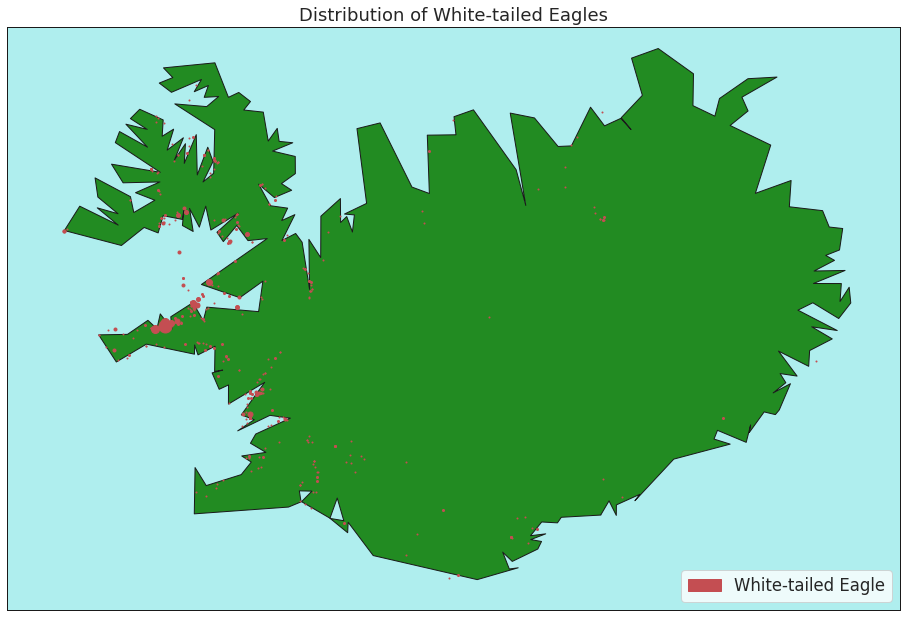

In [26]:
# First, we make a seperate dataframe that only contains the White-Tailed Eagles (Ísl: Haförn)
eagles = birds[birds["vernacularName"] == "White-tailed Eagle"]
# Second, we make a map by calling our helper function, make_map()
map = make_map()
# Third, we plot the location of the Eagles on our map by using plot_birds()
plot_birds(eagles, map)
eagle_patch = mpatches.Patch(color="r", label="White-tailed Eagle")
plt.legend(handles=[eagle_patch], loc="lower right")
plt.title("Distribution of White-tailed Eagles")
plt.show()

We can also plot the locations of multiple different species. Here we compare locations of [White-tailed Eagles](https://ebird.org/species/whteag) and [Short-eared Owls](https://ebird.org/species/sheowl):

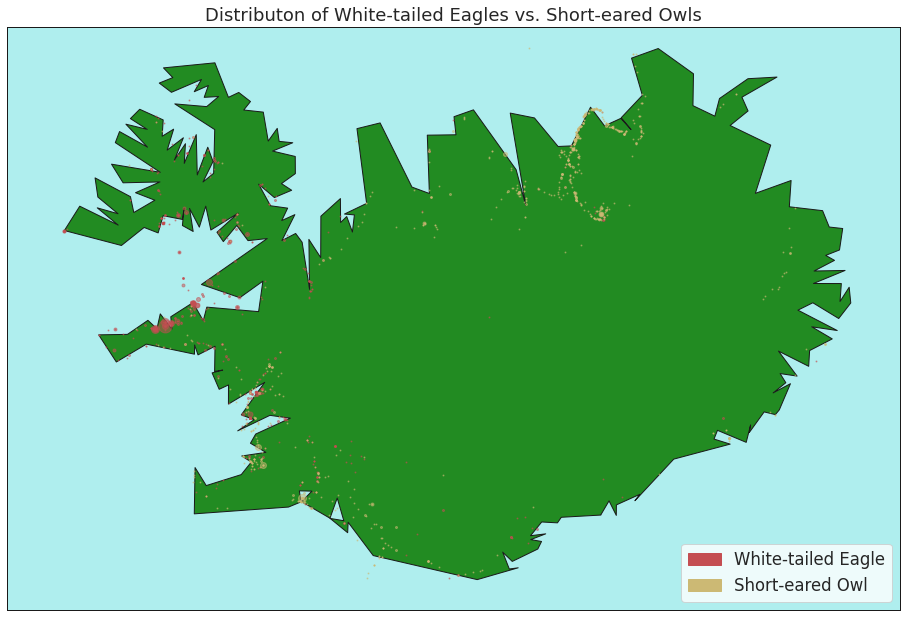

In [27]:
# Dataframe of Short-Eared Owls (Ísl: Brandugla)
shortEaredOwls = birds[birds["vernacularName"] == "Short-eared Owl"]


map = make_map()

# Here we set the alpha level to 0.5 to deal with overlapping markers 
plot_birds(eagles, map, "ro", .5) 
plot_birds(shortEaredOwls, map, "yo", .5)

owl_patch = mpatches.Patch(color="y", label="Short-eared Owl")
plt.legend(handles=[eagle_patch, owl_patch], loc="lower right")
plt.title("Distributon of White-tailed Eagles vs. Short-eared Owls")
plt.show()

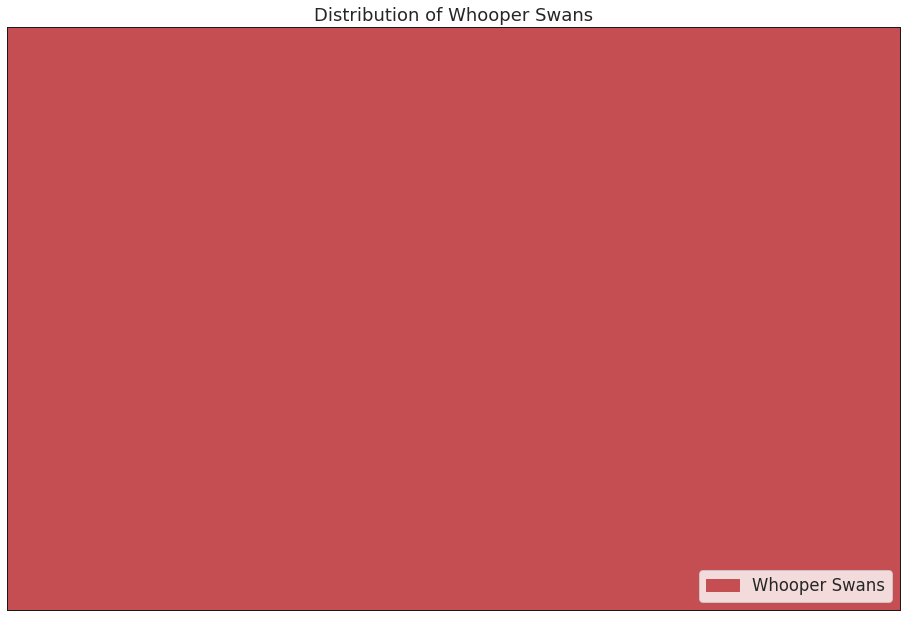

In [28]:
swans = birds[birds["vernacularName"] == "Whooper Swan"]

map = make_map()

plot_birds(swans, map)
swan_patch = mpatches.Patch(color="r", label="Whooper Swans")
plt.legend(handles=[swan_patch], loc="lower right")
plt.title("Distribution of Whooper Swans")
plt.show()

## Heat maps

In [29]:
# frame         pandas DataFrame
# year_start    year to start counting from (optional)
def make_heatmap(frame, year_start=1900):
    frame = frame[(frame["year"] >= year_start)]
    heatmap_prep = (frame.pivot_table(index=frame['year'],
                                       columns=frame['month'],
                                       values='individualCount', aggfunc=np.sum))
    return sns.heatmap(heatmap_prep, cmap='Reds')

In [30]:
goldcrests = birds[birds["vernacularName"] == "Goldcrest"]
goldcrests.head()

,vernacularName,icelandicName,verbatimScientificName,order,family,genus,specificEpithet,eventDate,year,month,day,stateProvince,locality,decimalLatitude,decimalLongitude,individualCount,iucnRedListCategory,rare
636189,Goldcrest,Glókollur,Regulus regulus,Passeriformes,Regulidae,Regulus,regulus,2011-10-05T00:00:00,2011,10,5,Höfuðborgarsvæði,Reykjavík--Öskjuhlíð,64.125885,-21.918823,1.0,LC,True
635882,Goldcrest,Glókollur,Regulus regulus,Passeriformes,Regulidae,Regulus,regulus,2018-12-26T00:00:00,2018,12,26,Norðurland eystra,Húsavík--Garðarsbraut 43,66.041870,-17.339558,1.0,LC,True
636612,Goldcrest,Glókollur,Regulus regulus,Passeriformes,Regulidae,Regulus,regulus,2019-09-09T00:00:00,2019,9,9,Norðurland eystra,Húsavík--Skógargerðisdalur,66.039750,-17.330560,2.0,LC,True
635180,Goldcrest,Glókollur,Regulus regulus,Passeriformes,Regulidae,Regulus,regulus,2014-09-11T00:00:00,2014,9,11,Höfuðborgarsvæði,Reykjavík--Hólavallagarður (cemetery),64.144570,-21.948195,1.0,LC,True
635518,Goldcrest,Glókollur,Regulus regulus,Passeriformes,Regulidae,Regulus,regulus,2012-08-28T00:00:00,2012,8,28,Höfuðborgarsvæði,Reykjavík--Fossvogur cemetery,64.123604,-21.909550,1.0,LC,True


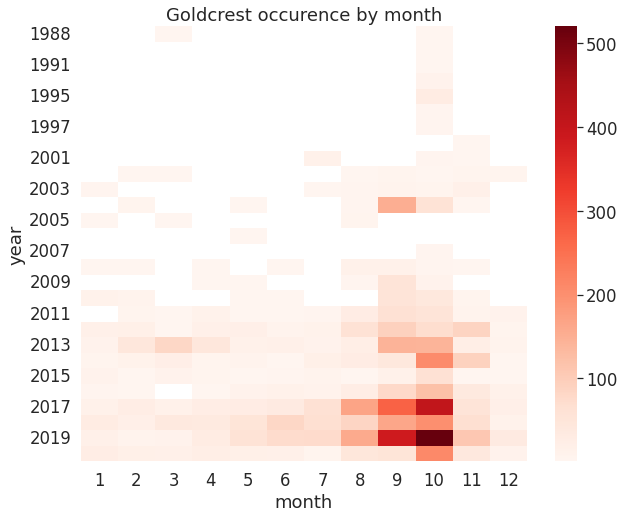

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = make_heatmap(goldcrests)
plt.title("Goldcrest occurence by month")
plt.show()

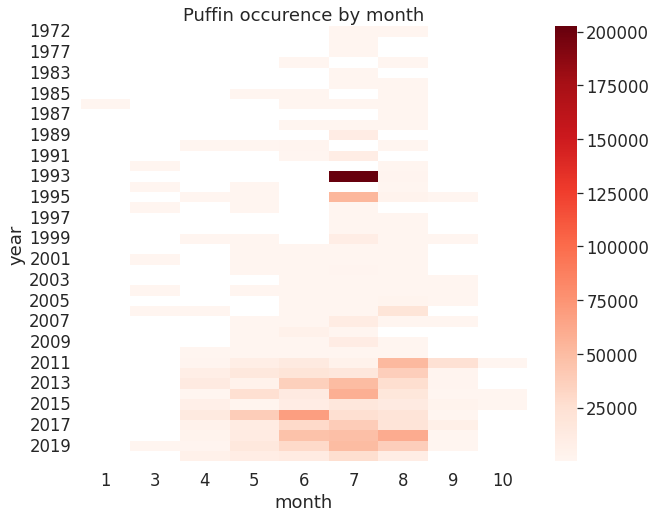

In [32]:
puffins = birds[birds["vernacularName"] == "Atlantic Puffin"]
puffins.head()
fig, ax = plt.subplots(figsize=(10, 8))
ax = make_heatmap(puffins)
plt.title("Puffin occurence by month")
plt.show()

## Machine Learning

In [33]:
# TODO: Remove everything exept year, month, day, decimalLatitude, decimalLongitude, and the y column. Possible y values  = ['genus', 'family']
from sklearn.preprocessing import OrdinalEncoder
y_column_name = 'genus'
data = birds[['year', 'month', 'day', 'decimalLatitude', 'decimalLongitude', y_column_name]]
# data = pd.get_dummies(data, columns=['genus'])
data = data.astype({"decimalLatitude":'int', "decimalLongitude":'int'}) 
data.drop(data[data.year < 1999].index, inplace=True)
enc = OrdinalEncoder()
data[[y_column_name]] = enc.fit_transform(data[[y_column_name]])
data.head()

,year,month,day,decimalLatitude,decimalLongitude,genus
365109,2018,5,10,66,-17,66.0
234911,2019,11,17,64,-21,161.0
1050,2011,5,12,63,-16,81.0
84141,2018,9,29,64,-22,143.0
249357,2009,4,21,66,-17,161.0


In [34]:
from sklearn.model_selection import train_test_split
def get_training_and_test_data(data, classifier_name, random_state=42, test_size=0.2, norm=False ):
    y = data[classifier_name]
    x = data.loc[:, data.columns != classifier_name]
    return train_test_split(x, y, test_size=test_size, random_state=random_state)


In [35]:
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier

class ClassifierSwitcher(BaseEstimator):
    def __init__(self, estimator=DecisionTreeClassifier()):
        self.estimator = estimator

    def fit(self, X, y=None):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import naive_bayes
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile

In [37]:
pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('feature_select', SelectKBest()),
    ('clf', ClassifierSwitcher()),
])

# feature_select_values = [10, 20, 30, 40, 50, 60, 70]
feature_select_values = [5]

parameters = [
    # {
    #     'clf__estimator': [DecisionTreeClassifier()],
    #     'variance_threshold__threshold': [0],
    #     'feature_select__k': feature_select_values,
    #     'clf__estimator__criterion': ["gini", "entropy"]
    # },
    # {
    #     'clf__estimator': [naive_bayes.GaussianNB()],
    #     'variance_threshold__threshold': [0],
    #     'feature_select__k': feature_select_values
    # },
    # {
    #     'clf__estimator': [naive_bayes.MultinomialNB()],
    #     'variance_threshold__threshold': [0],
    #     'feature_select__k': feature_select_values
    # },
    {
        'clf__estimator': [RandomForestClassifier()],
        'variance_threshold__threshold': [0],
        'feature_select__k': feature_select_values,
        'clf__estimator__criterion': ["gini"],
        'clf__estimator__n_estimators': [40],
        'clf__estimator__max_depth': [300]
    }
]

grid_search = GridSearchCV(pipeline, parameters, n_jobs=2)

# cv=184
# TODO: Split data to train and test
x_train, x_test, y_train, y_test = get_training_and_test_data(data, y_column_name)
grid_search.fit(*(data.loc[:, data.columns != y_column_name],data[y_column_name]))
print(grid_search.best_estimator_) # Finding the best estimator
clf = grid_search.best_estimator_

selection = SelectKBest(k= grid_search.best_params_["feature_select__k"]).fit(x_train, y_train)
x_train = selection.transform(x_train)
# clf = naive_bayes.MultinomialNB()
# clf.fit(x_train, y_train)
x_test = selection.transform(x_test)
print(classification_report(y_test, clf.predict(x_test)))

Pipeline(steps=[('variance_threshold', VarianceThreshold(threshold=0)),
                ('feature_select', SelectKBest(k=5)),
                ('clf',
                 ClassifierSwitcher(estimator=RandomForestClassifier(max_depth=300,
                                                                     n_estimators=40)))])
              precision    recall  f1-score   support

         0.0       0.24      0.04      0.07      3096
         1.0       1.00      1.00      1.00         1
         2.0       0.00      0.00      0.00         6
         3.0       1.00      0.33      0.50         3
         4.0       1.00      0.07      0.12        15
         5.0       0.00      0.00      0.00         3
         6.0       0.13      0.02      0.03       386
         7.0       0.00      0.00      0.00         3
         8.0       0.44      0.08      0.14        50
         9.0       0.18      0.48      0.26     11837
        10.0       0.21      0.13      0.16      4399
        11.0       0.14    